In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool


import text_processor as tp

In [35]:
%matplotlib inline

In [36]:
with open('pickles/amazon/data_set.pickle', 'rb') as data:
    data_set = pickle.load(data)

### Preprocess the dataset

In [55]:
print(data_set.head())
print(data_set.count())

                                             content  rating  sentiment
0  This kindle is light and easy to use especiall...     5.0        1.0
1  Didnt know how much i'd use a kindle so went f...     4.0        1.0
2  I am 100 happy with my purchase. I caught it o...     5.0        1.0
3  Solid entry level Kindle. Great for kids. Gift...     5.0        1.0
4  This make an excellent ebook reader. Don't exp...     5.0        1.0
content      10628
rating       10628
sentiment    10628
dtype: int64


In [89]:
def process_txt(df):
    """
    Apply clean_text method of text_processor in the column 'content'
    """
    df['cleaned_text'] = df['content'].apply(tp.clean_text)
    return df

In [74]:
def parallelize_df(df, func, n=5):
    """
    Split the dataframe df into 'n' dataframes and parallely apply 'func'
    on each dataframe using multiprocessing
    """
    df_split = np.array_split(df, n)
    pool = Pool(n)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [76]:
%%time
# perform text preprocessing steps on the contents of data_set
processed_df = parallelize_df(data_set, process_txt)


CPU times: user 87.9 ms, sys: 101 ms, total: 189 ms
Wall time: 33.1 s


In [77]:
processed_df.head()

,content,rating,sentiment,cleaned_text
0,This kindle is light and easy to use especiall...,5.0,1.0,kindle light easy use especially beach
1,Didnt know how much i'd use a kindle so went f...,4.0,1.0,know much would use kindle go low end happy ev...
2,I am 100 happy with my purchase. I caught it o...,5.0,1.0,happy purchase catch sale really good price no...
3,Solid entry level Kindle. Great for kids. Gift...,5.0,1.0,solid entry level kindle great kid gift kid fr...
4,This make an excellent ebook reader. Don't exp...,5.0,1.0,make excellent ebook reader expect much device...


### Positive words cloud

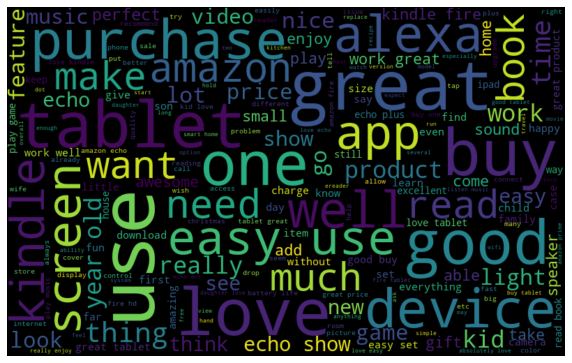

In [78]:
pos_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == 1]])
pos_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10,7))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative words cloud

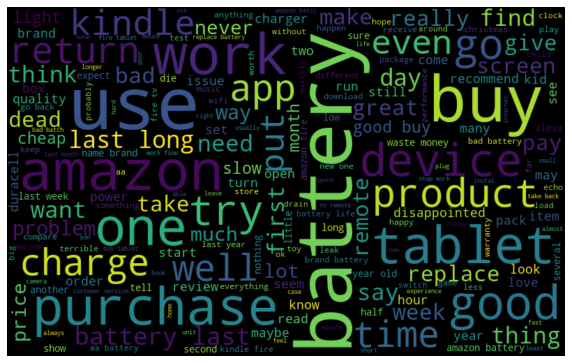

In [79]:
neg_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == 0]])
neg_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10,7))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Complaints word cloud

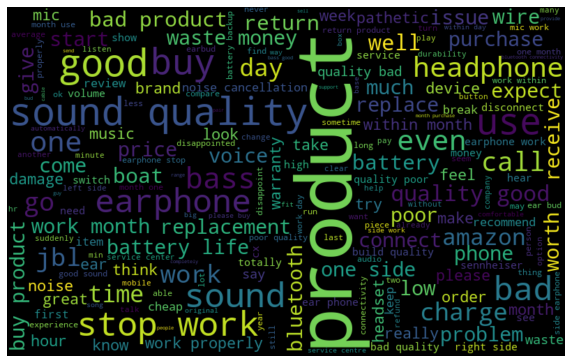

In [81]:
complaint_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == 2]])
comp_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(complaint_words)

plt.figure(figsize=(10,7))
plt.imshow(comp_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Split data for training and testing

In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(processed_df['cleaned_text'], 
                                                    processed_df['sentiment'], 
                                                    test_size = 0.2,
                                                    random_state = 10)

In [83]:
print(X_train.shape)
print(X_test.shape)

(8502,)
(2126,)


### Create TFIDF vector

In [84]:
tfidf = TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,2),
                       max_df=1.0,
                       min_df=10,
                       max_features=300,
                       norm='l2',
                       sublinear_tf=True)

In [85]:
train_features = tfidf.fit_transform(X_train).toarray()
print(train_features.shape)

(8502, 300)


In [86]:
test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(2126, 300)


In [87]:
train_labels = Y_train
test_labels = Y_test

### Save required objects for later use

In [88]:
with open('pickles/amazon/processed_df.pickle', 'wb') as output:
    pickle.dump(processed_df, output)
    
with open('pickles/amazon/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
with open('pickles/amazon/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
with open('pickles/amazon/Y_train.pickle', 'wb') as output:
    pickle.dump(Y_train, output)
    
with open('pickles/amazon/Y_test.pickle', 'wb') as output:
    pickle.dump(Y_test, output)
    
with open('pickles/amazon/train_features.pickle', 'wb') as output:
    pickle.dump(train_features, output)
    
with open('pickles/amazon/test_features.pickle', 'wb') as output:
    pickle.dump(test_features, output)
    
with open('pickles/amazon/train_labels.pickle', 'wb') as output:
    pickle.dump(train_labels, output)
    
with open('pickles/amazon/test_labels.pickle', 'wb') as output:
    pickle.dump(test_labels, output)

with open('pickles/amazon/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)